In previous posts, we've shown how to solve inverse problems to estimate the coefficients $q$ in a PDE from measured values of the solution $u$.
The computational problem that we aimed to solve was to minimize the functional

$$J(u, q) = E(u) + R(q)$$

where $E$ is a *misfit* functional and $R$ the *regularization* functional.
The solution was subject to a constraint

$$F(u, q) = 0$$

where $F$ is some partial differential equation.
Provided that $F$ is nice enough we can calculate derivatives of this functional using the adjoint method and then apply some sort of descent method.
Another important fact we'll use below is that the PDE has a solution operator $G(q)$.
We can then think of this in terms of a *reduced* objective functional, which in a gross abuse of notation we'll also write as $J$:

$$J(q) = E(G(q)) + R(q).$$

We can also give this problem a statistical interpretation.
The functional

$$\pi(q) = Z^{-1}e^{-J(q)}$$

is the Bayesian posterior density after having taken the measurements given the prior information that $R(q)$ averages to some value.
(The scalar $Z$ is a normalizing constant that we effectively cannot calculate.)
The *maximum a posteriori* or MAP estimator is the value of $q$ that maximizes the posterior density.
But maximizing the posterior density is the same as minimizing its negative logarithm.
This gets us right back to our original problem of minimizing the objective functional $J$.

Computing the most likely value of the parameters given the observations provides valuable information when the measurement errors are normally distributed and when the forward map $G$ is linear or only mildly nonlinear.
For many problems, however, the measurement errors are not normal or the forward map is not approximately linear.
The MAP estimator might still be useful, but it also might not be all that informative and it might not even exist.

In this post, I'll describe a procedure by which we can instead draw random samples from the posterior distribution.
Assuming that our sampling procedure is ergodic, we can approximate expectations of an arbitrary functional $f$ as a weighted sum:

$$\langle f\rangle = \int f(q)\,\mathrm{d}\pi(q) \approx \frac{1}{N}\sum_n f(q_n).$$

It doesn't make sense to seek the most likely value of the parameters when there are many local maxima of the posterior density or when the posterior is so flat near the maximum that it can't be located with reasonable accuracy.
In this circumstances, we're better off accepting the uncertainty for what it is and factoring this into what we do with our answer(s).

The classic approach for sampling from the posterior distribution is the [Metropolis algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm), a form of Markov-chain Monte Carlo that I'll assume you're familiar with.
One of the challenges in using this algorithm is that it scales poorly to dimensions much more than 10 or 12, and if you're doing PDE problems the dimensions are often in the thousands.
Here we'll try here an approach called the [Metropolis-adjusted Langevin](https://en.wikipedia.org/wiki/Metropolis-adjusted_Langevin_algorithm) algorithm or MALA.
The key innovation of MALA is to incorporate drift towards higher-probability regions of parameter space into the proposal density.
To be more specific, consider the [Itô diffusion](https://en.wikipedia.org/wiki/It%C3%B4_diffusion)

$$\dot q = \frac{1}{2}M^{-1}\mathrm{d}\log \pi(q) + M^{-\frac{1}{2}}\dot B,$$

where $M$ is some symmetric and positive-definite linear operator and $B$ is standard Brownian motion.
Under a few reasonable hypotheses on $\pi$, the limiting distribution of this process is $\pi$.
Of course we can't in general solve this SDE exactly, but we can discretize and I'll describe how below.

### Generating the exact data

We'll use the same input data and exact solution as the previous demo -- a random trigonometric polynomial for the boundary data and a spike in the conductivity to make it depart appreciably from the equivalent solution for homogeneous data.

In [1]:
import firedrake
Lx = firedrake.Constant(1.0)
Ly = firedrake.Constant(1.0)
nx, ny = 32, 32
mesh = firedrake.RectangleMesh(nx, ny, float(Lx), float(Ly), diagonal='crossed')
Q = firedrake.FunctionSpace(mesh, 'CG', 2)
V = firedrake.FunctionSpace(mesh, 'CG', 2)

In [2]:
import numpy as np
from numpy import random, pi as π
from firedrake import sin, cos, Constant
x = firedrake.SpatialCoordinate(mesh)

def random_fourier_series(std_dev, num_modes, exponent, seed=1):
    rng = random.default_rng(seed=seed)
    A = std_dev * rng.standard_normal((num_modes, num_modes))
    B = std_dev * rng.standard_normal((num_modes, num_modes))
    
    expr = Constant(0)
    for k in range(num_modes):
        for l in range(int(np.sqrt(num_modes**2 - k**2))):
            ϕ = π * (k * x[0] / Lx + l * x[1] / Ly)
            Z = 1 + (k**2 + l**2)**(exponent / 2)
            a_kl = Constant(A[k, l] / Z)
            b_kl = Constant(B[k, l] / Z)
            expr = expr + a_kl * sin(ϕ) + b_kl * cos(ϕ)
    
    return expr

In [3]:
from firedrake import interpolate
g = interpolate(random_fourier_series(1.0, 6, 1, seed=1), V)

In [4]:
from firedrake import inner, min_value, max_value, Constant
a = -Constant(8.)
r = Constant(1/4)
y = Constant((0.4, 0.5))
q_true = interpolate(a * max_value(0, 1 - inner(x - y, x - y) / r**2), Q)

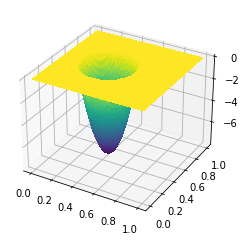

In [5]:
firedrake.trisurf(q_true);

In [6]:
b = Constant(6.)
R = Constant(1/4)
η = Constant((0.7, 0.5))
f = interpolate(b * max_value(0, 1 - inner(x - η, x - η) / R**2), V)

In [7]:
from firedrake import exp, grad, dx, ds
k = Constant(1.)
h = Constant(10.)
u_true = firedrake.Function(V)
v = firedrake.TestFunction(V)
F = (
    (k * exp(q_true) * inner(grad(u_true), grad(v)) - f * v) * dx +
    h * (u_true - g) * v * ds
)

In [8]:
opts = {
    'solver_parameters': {
        'ksp_type': 'preonly',
        'pc_type': 'lu',
        'pc_factor_mat_solver_type': 'mumps'
    }
}
firedrake.solve(F == 0, u_true, **opts)

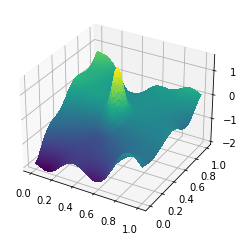

In [9]:
firedrake.trisurf(u_true);

### Generating the observational data

In the inverse problem tutorial, we only had to generate a single realization of spatial white noise.
Here we'll have to generate many realizations, so we'll wrap this up into a class that will store all the data structures we need.
We'll also abstract a bit over what the covariance operator is.
In the inverse problem tutorial we used the mass matrix as the covariance operator, and we will do that again here to generate the observational data.
As we'll see later, we'll also use this to generate the random noise used in the sampling algorithm, which will have non-trivial spatial correlations.
The important thing that the code below does is to apply the inverse of only one of the Cholesky factors instead of both.
We had to use the PETSc API to do this, since it isn't natively supported at the Firedrake level and arguably it shouldn't be.

In [10]:
from firedrake import assemble
from firedrake.petsc import PETSc
area = assemble(Constant(1) * dx(mesh))

class NoiseGenerator:
    def __init__(
        self,
        function_space,
        covariance=None,
        generator=random.default_rng()
    ):
        if covariance is None:
            ϕ = firedrake.TrialFunction(function_space)
            ψ = firedrake.TestFunction(function_space)
            covariance = inner(ϕ, ψ) * dx

        M = assemble(covariance, mat_type='aij').M.handle
        ksp = PETSc.KSP().create()
        ksp.setOperators(M)
        ksp.setUp()
        
        pc = ksp.pc
        pc.setType(pc.Type.CHOLESKY)
        pc.setFactorSolverType(PETSc.Mat.SolverType.PETSC)
        pc.setFactorSetUpSolverType()
        L = pc.getFactorMatrix()
        pc.setUp()
        
        self.rng = generator
        self.function_space = function_space
        self.preconditioner = pc
        self.cholesky_factor = L
        
        self.rhs = firedrake.Function(self.function_space)
        self.noise = firedrake.Function(self.function_space)
        
    def __call__(self):
        z, ξ = self.rhs, self.noise
        N = len(z.dat.data_ro[:])
        z.dat.data[:] = self.rng.standard_normal(N)

        L = self.cholesky_factor
        with z.dat.vec_ro as Z:
            with ξ.dat.vec as Ξ:
                L.solveBackward(Z, Ξ)
                Ξ *= np.sqrt(area / N)
                
        return ξ.copy(deepcopy=True)

In [11]:
white_noise_generator = NoiseGenerator(
    function_space=V,
    generator=random.default_rng(seed=1066)
)

In [12]:
û = u_true.dat.data_ro[:]
signal = û.max() - û.min()
signal_to_noise = 50
σ = firedrake.Constant(signal / signal_to_noise)

u_obs = u_true.copy(deepcopy=True)
ξ = white_noise_generator()
u_obs += σ * ξ

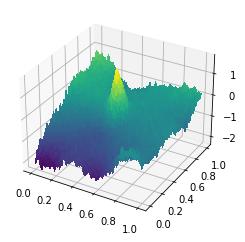

In [13]:
firedrake.trisurf(u_obs);

### Sampling

The sampling procedure that we'll use works by approximating paths of an Itô diffusion.
Many of the papers you'll come across on MALA or on diffusion processes assume a constant volatility matrix or inverse covariance of the added noise.
I've included a factor $M$, which we'll refer to as a *preconditioning* matrix.
The kinds of posterior distributions we encounter in data assimilation properties are often highly anisotropic in parameter space.
Making a good choice of preconditioning operator is a virtual necessity if for efficiently sampling from the posterior.

The theoretically optimal choice is to $M$ to be the second derivative or Hessian of the negative log-posterior.
Pyadjoint can apply a Hessian action for us, and we can then use the conjugate gradient method with an appropriate preconditioner to solve for the drift.
But to calculate the diffusion we need an inverse *square root* of the Hessian operator, and that will require us to call in to SLEPc.

The worst thing we could do is nothing because of the mesh-dependence problems that I described in the previous post on inverse problems.
The finite element mass matrix is the absolute least you can do without committing a criminal offense -- it represents the map from the dual of $L^2$ back to $L^2$ itself.

To do better than just the mass matrix, we can try to come up with a linear operator that will roughly recover the spectral asymptotics of the Hessian but which we can more easily express as a sparse matrix -- the Hessian will be dense.
Then we can just reuse the noise sampler class that I wrote above to compute the Cholesky factorization and generate random variables with this operator as its inverse covariance matrix.
Here we'll use an operator $M$ with the weak form

$$\langle M\phi, \psi\rangle = \int_\Omega\left(\phi\cdot\psi + \ell^2\nabla\phi\cdot\nabla\psi\right)dx$$

where $\ell$ is some length scale, which I'll take to be the diameter of the domain.
If the parameters $q$ live in the Sobolev space $H^1(\Omega)$, then $M$ is the canonical map from $H^1(\Omega)$ to its dual.
The length scale $\ell$ is there to make the units work out right.

In [14]:
ϕ, ψ = firedrake.TestFunction(Q), firedrake.TrialFunction(Q)
ℓ = firedrake.sqrt(Lx * Ly)
M = (ϕ * ψ + ℓ**2 * inner(grad(ϕ), grad(ψ))) * dx

diffusion_generator = NoiseGenerator(
    function_space=Q,
    covariance=M,
    generator=random.default_rng(1453)
)

We'll again start with the very blunt initial guess that the log-conductivity is 0 to initialize the problem.

In [15]:
q = firedrake.Function(Q)
u = firedrake.Function(V)
F = (
    (k * exp(q) * inner(grad(u), grad(v)) - f * v) * dx +
    h * (u - g) * v * ds
)
firedrake.solve(F == 0, u, **opts)

As I alluded to earlier, our proposal distribution for the MCMC algorithm is based on integrating the SDE

$$\dot q = -\frac{1}{2}M^{-1}\mathrm{d}J(q) + M^{-\frac{1}{2}}\dot B$$

where $B$ is standard Brownian motion.
The Euler-Maruyama scheme to integrate this equation for a single step of length $\delta t$ is

$$q^* = q - \frac{\delta t}{2}M^{-1}\mathrm{d}J(q) + \delta t^{\frac{1}{2}}M^{-\frac{1}{2}}\delta B.$$

But a naive integration of the SDE may have a different limiting distribution from the SDE itself, and it may even diverge.
To fix this problem, we'll use a Metropolis-style accept/reject step.
Having generated a proposal $q^*$, we'll accept it with probability

$$\alpha = \min\left\{1, \frac{\pi(q^*)\cdot\rho(q^*\to q)}{\pi(q)\cdot\rho(q\to q^*)}\right\}$$

where $\pi$ is the posterior density and $\rho$ is the transition density.
We don't know the normalizing factor in the posterior density, but by taking the ratio of the two this factor cancels:

$$\ln\frac{\pi(q^*)}{\pi(q)} = J(q) - J(q^*).$$

In the classic random walk Metropolis-Hastings algorithm, the ratio of the transition density from the current state to the proposed state usually cancels because the transition density is symmetric -- the chance of going from $q$ to $q^*$ is equal to the chance of going from $q^*$ back to $q$.
The algorithm that we're using here lacks this symmetry because of the gradient flow term in the proposal density.
The transition density can be written as:

$$\rho(q \to q^*) = Z^{-1}\exp\left\{-\frac{1}{2\tau}\left\|q^* - q + \frac{1}{2}\tau M^{-1}dJ(q)\right\|_M^2\right\}$$

Once again, the normalizing factor $Z$ is not directly computable but we're only interested in ratios:

$$2\tau\ln\frac{\rho(q^* \to q)}{\rho(q \to q^*)} = \left\|q^* - q + \frac{1}{2}\tau M^{-1}dJ(q)\right\|_M^2 - \left\|q - q^* + \frac{1}{2}\tau M^{-1}dJ(q^*)\right\|_M^2$$

This means that we need variables to store both the parameter guess, the PDE solution, and the derivative of the log-posterior at both the current state and the proposal at every stage of the iteration.

In [16]:
from firedrake_adjoint import Control, ReducedFunctional

α = Constant(1e-1)
drift_solver = firedrake.LinearSolver(assemble(M), **opts)
z = firedrake.Function(Q)
z_n = firedrake.Function(Q)
q_n = firedrake.Function(Q)
u_n = firedrake.Function(V)

J = 0.5 * (
    ((u - u_obs) / σ)**2 +
    α**2 * inner(grad(q), grad(q))
) * dx

q̂ = Control(q)
Ĵ = ReducedFunctional(assemble(J), q̂)
dĴ_dq = Ĵ.derivative()
drift_solver.solve(z, dĴ_dq)

I've tuned the step length for the Euler-Maruyama integration to get a good accept/reject ratio and (as we'll see later) to get a good decorrelation time.

In [17]:
τ = firedrake.Constant(5 / 6)

At the end of the loop I've also added a call to clear the tape for adjoint annotation.
If you don't clear the tape, the simulation can eat up more and more memory as it goes on.

In [18]:
from firedrake import sqrt, interpolate, replace, energy_norm
import firedrake_adjoint
import tqdm

us = []
qs = []
Js = []

rng = random.default_rng(seed=42)

num_accepted = 0
num_rejected = 0

num_samples = 3000
progress = tqdm.trange(num_samples)
for sample in progress:
    δB = diffusion_generator()
    q_n = interpolate(q - 0.5 * τ * z + sqrt(τ) * δB, Q)
    F_n = replace(F, {q: q_n, u: u_n})
    firedrake.solve(F_n == 0, u_n, **opts)
    
    J_n = replace(J, {q: q_n, u: u_n})
    q̂ = Control(q_n)
    Ĵ = ReducedFunctional(assemble(J_n), q̂)
    dĴ_dq = Ĵ.derivative()
    drift_solver.solve(z_n, dĴ_dq)

    δln_π = float(assemble(J - J_n))
    δq = interpolate(q_n - q + 0.5 * τ * z, Q)
    δq_n = interpolate(q - q_n + 0.5 * τ * z_n, Q)
    δln_ρ = float(
        assemble(energy_norm(M, δq) - energy_norm(M, δq_n)) / (2 * τ)
    )
    alpha = np.exp(δln_ρ + δln_π)
    roll = rng.uniform(0, 1)
    accept = roll > 1 - alpha
    num_accepted += accept
    num_rejected += not accept
    progress.set_description(
        f'Accepted, rejected: {num_accepted}, {num_rejected} |'
    )
    
    if accept:
        q.assign(q_n)
        u.assign(u_n)
        z.assign(z_n)

    qs.append(q.copy(deepcopy=True))
    us.append(u.copy(deepcopy=True))
    Js.append(float(assemble(J_n)))
    
    firedrake_adjoint.get_working_tape().clear_tape()

Accepted, rejected: 1795, 1205 |: 100%|██████████| 3000/3000 [22:37<00:00,  2.21it/s]


This run took only a few minutes, but I've overheard statistics grad students talk about Monte Carlo simulations runing overnight or even for several days.
Geyer's introduction to the [Handbook of Markov Chain Monte Carlo](https://www.mcmchandbook.net) -- which I highly recommend reading, it's available for free from the book website -- implies that overnight is a bare minimum to show due dilligence.

Another nice feature of this algorithm is that it's easy to run several chains in parallel.
We haven't done this here, but comparing results across many chains is common to several approaches for a posteriori sanity checking.

Now that we have our samples, it's time to actually analyze the results and do something with them.

### Burn-in

The probability distribution of the samples eventually converges to the posterior density, but in the initial stages of the chain, the distribution can be very far off from the limiting value.
We can see that by plotting the values of the negative log posterior (or the objective functional if you're still in the optimization frame of mind).

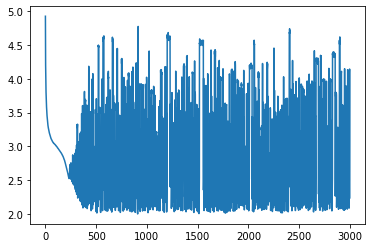

In [19]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots()
axes.plot(Js);

The objective functional decreases almost monotonically for the first 200 steps or so; the chain is effectively doing deterministic gradient descent towards a more probable region of parameter space.
This phenomenon is referred to as the *burn-in*.
It's common to discard all of the samples from the burn-in phase.
From here on out we'll forget these iterations entirely.

In [20]:
num_burn_steps = 200
qs = qs[num_burn_steps:]

We could have avoided this ad-hoc, manual step by taking a few iterations of an optimization procedure to approximate the maximizer of the posterior distribution and starting the Markov chain from there.

The trace plot we showed above helps us diagnose where burn-in occurs, but doesn't give a very good idea of the distribution of $J$ values.
For that we can make a histogram.

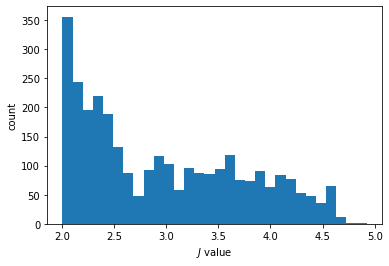

In [21]:
fig, axes = plt.subplots()
axes.hist(Js, 30)
axes.set_xlabel('$J$ value')
axes.set_ylabel('count');

The histogram shows some signs of bimodality, which is definitely worth investigating.
There might be a local maximum of the probability distribution separate from the true mode.

Having tossed the initial deterministic junk, we can take a guess at what the posterior mean of the distribution is.

In [22]:
q_avg = firedrake.Function(Q)
q_avg.dat.data[:] = np.mean(
    np.array([q.dat.data_ro[:] for q in qs]), axis=0
)

Note how similar this looks to the maximum a posteriori estimate that we obtained in the previous demo.

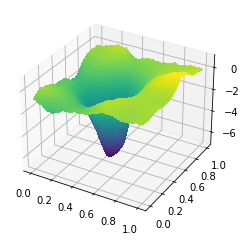

In [23]:
firedrake.trisurf(q_avg);

### Sample size

After we've discarded the samples from the burn-in phase, the successive states of the Markov chain are still correlated and this begs the question of how many independent samples we actually obtained.
Assessing the *effective sample size* turns out to be surprisingly subtle.
The idealized, mathematical definition of the effective sample size, assuming that we could calculate the correlations exactly, is

$$N_{\text{eff}} = \frac{N}{1 + 2\sum_{k = 1}^\infty r_k}$$

where $r_k$ is the [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation) at lag $k$.
Let's suppose for now that we're only interested in calculating the effective number of samples of the negative log-posterior $J$.
This is a scalar quantity so it's much cheaper to compute on, which is good because our first few attempts are going to go down in flames.
The autocorrelation is defined as

$$r_k = \langle (J(q_{i + k}) - \mu)(J(q_i) - \mu)\rangle / \sigma^2$$

where $\mu$ and $\sigma$ are the mean and standard deviation of $J$.
We could try to approximate the autocorrelation from the samples themselves.

In [24]:
Js = Js[num_burn_steps:]
J_avg = np.mean(Js)
J_std = np.sqrt(np.mean((Js - J_avg)**2))
print(f'Mean, standard deviation of J: {J_avg:5.3f}, {J_std:5.3f}')

autocorr = np.zeros_like(Js)
autocorr[0] = 1.0
for k in range(1, len(Js)):
    autocorr[k] = np.mean(
        (Js[:-k] - J_avg) * (Js[k:] - J_avg)
    ) / J_std**2

Mean, standard deviation of J: 2.959, 0.797


The empirical autocorrelation goes totally bonkers at large lags because there aren't enough samples spaced that far apart to adequately estimate the value of the autocorrelation function.

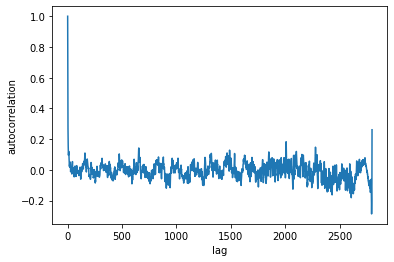

In [25]:
fig, axes = plt.subplots()
axes.plot(autocorr)
axes.set_ylabel('autocorrelation')
axes.set_xlabel('lag');

Just to really drive home how nonsensical this is, let's calculate the denominator in the expression for the effective sample size.

In [26]:
1 + 2 * np.sum(autocorr[1:])

-37.79065108326468

wat.

We could try an alternative formula instead that weights every autocorrelation value by $1 / N$.
This weighting is guaranteed to produce a positive-definite autocorrelation function (see this [SO answer](https://stats.stackexchange.com/a/294410)), unlike the form I used above.
Feels a little ad-hoc to me but ok?

In [27]:
autocorr = np.zeros_like(Js)
autocorr[0] = 1.0
N = len(Js)
for k in range(1, N):
    autocorr[k] = np.sum(
        (Js[:-k] - J_avg) * (Js[k:] - J_avg)
    ) / J_std**2 / N

Slightly less horrific-looking.

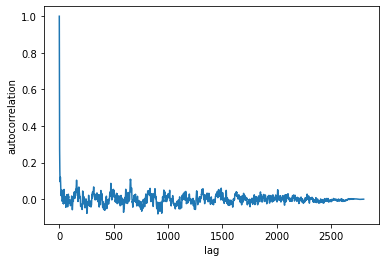

In [28]:
fig, axes = plt.subplots()
axes.plot(autocorr)
axes.set_xlabel('lag')
axes.set_ylabel('autocorrelation');

Now let's see what the correlation time is.

In [29]:
1 + 2 * np.sum(autocorr[1:])

-6.661338147750939e-16

This would imply that we have a few quadrillion independent samples which, again, I find to be highly suspect.

Hopefully by this point you're convinced that estimating the effective sample size from the samples themselves is very not trivial, so now I'll refer you to a great paper called [A Comparison of Methods for Computing Autocorrelation Time](https://arxiv.org/abs/1011.0175) by Madeleine Thompson.
One of the methods she tested is to use *batch means* and this is what we'll use below.
The idea of batch means is to divide the $n$ samples into $m$ batches, and to compare the overall sample variance with the variance of the batch means.
For the method to converge, the number of batches and the size of each batch has to go to infinity.
A common choice is to take $m = \sqrt{n}$, or some other power.

In [30]:
batch_size = int(np.sqrt(N / 2))
num_batches = int(N / batch_size)
batch_means = np.zeros(num_batches)
for index in range(num_batches):
    batch_means[index] = np.mean(
        Js[index * batch_size: (index + 1) * batch_size]
    )
    
batch_std = np.sqrt(np.mean((batch_means - J_avg)**2))
correlation_time = batch_size * batch_std / J_std

print(f"""
    batch size:     {batch_size}
    total std dev:  {J_std:5.3f}
    batch std dev:  {batch_std:5.3f}
    corr time:      {correlation_time:5.3f}
""")


    batch size:     37
    total std dev:  0.797
    batch std dev:  0.324
    corr time:      15.061



This suggests that about one out of every 12 Monte Carlo samples is effectively independent, which is pretty good.
We might be able to improve this further by tuning the stepsize or by using a better choice of preconditioner $M$.

There are other ways to estimate effective sample size and the Thompson paper I linked above does a nice comparison of them on several example problems.
Nonetheless, I'm surprised to have found only one paper that compared them.
It's been cited about 50 times but never published in a peer-reviewed journal.
I'm also surprised to have come across so many papers that don't report how they computed the effective sample size or even what it was for their simulation.

A few other subtle points are worth mentioning here too.
The effective sample size can differ depending on exactly what quantity you're measuring.
For example, let's see what the effective sample size is for the cosine of the angle between the estimated parameter and the true value.

In [31]:
from firedrake import norm
def angle(p, q):
    cos_θ = float(assemble(p * q * dx) / (norm(p) * norm(q)))
    return np.arccos(cos_θ)

angles = np.array([angle(q, q_true) for q in qs])
angles_avg = np.mean(angles)
angles_std = np.sqrt(np.mean((angles - angles_avg)**2))
print(f'Mean, stddev of ∠(q, q_true): {angles_avg:5.3f}, {angles_std:5.3f}')

Mean, stddev of ∠(q, q_true): 0.489, 0.044


In [32]:
batch_means = np.zeros(num_batches)
for index in range(num_batches):
    batch_means[index] = np.mean(
        angles[index * batch_size: (index + 1) * batch_size]
    )
    
batch_std = np.sqrt(np.mean((batch_means - angles_avg)**2))
correlation_time = batch_size * batch_std / angles_std

print(f"""
    batch size:     {batch_size}
    total std dev:  {angles_std:5.3f}
    batch std dev:  {batch_std:5.3f}
    corr time:      {correlation_time:5.3f}
""")


    batch size:     37
    total std dev:  0.044
    batch std dev:  0.015
    corr time:      12.347



We have just a bit more effective samples of the angle between $q$ and the true value as we do of $J(q)$.

A second and perhaps more surprising fact is that, if the autocorrelation function really is negative, you can have more effective samples than total samples.
It's possible to specially design the proposal distribution to make the autocorrelation function at odd lags negative; this is the idea behind [antithetic updates](https://doi.org/10.1007/978-1-4612-2920-9_10).
There's a nice discussion of the unintuitive behaviors of effective sample size [here](https://golem.ph.utexas.edu/category/2014/12/effective_sample_size.html).

### Reflection

I've worked on inverse problems for several years from a purely optimization point of view.
I knew about Monte Carlo approaches, but I'd written them off for a while because I had the impression that they scale very badly to high dimensions.
So I was very happy to hear about approaches like MALA or Hamiltonian Monte Carlo that overcome the dimensionality curse.
I'd spent a lot of time beating my head against the wall trying (and failing) to implement more robust optimization algorithms and preconditioners to solve an inverse problem that doesn't even have a unique solution.
So I find it more appealing on a philosophical level to confront the possible non-uniqueness head-on by sampling directly from the posterior distribution.
This isn't to say that MCMC sampling is a cakewalk.
Here I touched on how estimating the effective sample size is a poorly-documented but necessary part of the workflow.
Things get worse when you consider the likelihood of sampling distinct regions of parameter space that are separated by a large potential barrier.
Even with these faults, I find the sampling approach to be a big improvement both in implementation feasibility and in what you can learn from the results over the optimization approach.